In [2]:
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(27)
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn

mean, std = (0.5,), (0.5,)

In [3]:
# Although Pytorch has MNIST dataset, we will be loading our own MNIST dataset from Kaggle, for this we 
# need to create a custom class as per Pytorch's documentation

class Dataset(object):
    """An abstract class representing a Dataset.
    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
    
class CustomImgDataset(Dataset):
    
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # we will be using "ToTensor() transform on the input, so our Numpy array must"
        # be of shape (H,W,C) and ToTensor() will convert it to (C,H,W)
        image = self.data.iloc[index, 1:].values.astype(np.uint8).reshape((28, 28, 1))
        label = self.data.iloc[index, 0]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label
    


In [4]:
# transforms input to Tensor, and normalize the input elements with the given mean and standard deviation
transform = transforms.Compose ([transforms.ToTensor(), transforms.Normalize(mean,std)])
train_dset = CustomImgDataset('/kaggle/input/mnist-in-csv/mnist_train.csv', transform=transform)
trainloader = torch.utils.data.DataLoader(train_dset, batch_size=64, shuffle=True)

test_dset = CustomImgDataset('/kaggle/input/mnist-in-csv/mnist_test.csv', transform=transform)
testloader = torch.utils.data.DataLoader(test_dset, batch_size=64, shuffle=False)

torch.Size([28, 28])


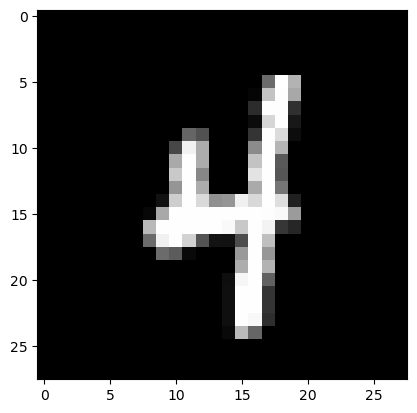

In [7]:
#Lets take a look at one of the image
def denormalize(tensor):
    tensor = tensor*0.5 + 0.5
    return tensor

def showimg(img):
    i = denormalize(img)
    plt.imshow(i, cmap='gray')

img, lbl = next(iter(trainloader))
img = img[17].view(28,-1)
showimg(img)

In [11]:
#Lets create our model
#the model will have fully connected layer1 -> Relu -> fully connected layer2 -> Relu -> fully connected layer3 -> logSoftmax

class CustomMNIST(nn.Module):
    #the __init__ method will call the __init__ method of nn.Module and just defines the various 
    #layers in the Neural network.
    #The connection and sequence of this layers will be defined in the "forward" function of this class
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128) #its upto you to choose the layer sizes
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10) #output here should be 10, for 10 classes for MNIST
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

model = CustomMNIST()        

In [13]:
#gets optimizer first, optimizer updates gradients
from torch import optim

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 3

for i in range(epochs):
    cum_loss = 0
    
    for images, labels in trainloader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward() #here gradient will be updated
        optimizer.step() #here weights will be updated
        
        cum_loss += loss.item()
    print("Epoch: {}, Training loss: {}".format(i, cum_loss/len(trainloader)))

Epoch: 0, Training loss: 1.02934491967977
Epoch: 1, Training loss: 0.38171539587506864
Epoch: 2, Training loss: 0.32117577533382596


Lets Make this model go Brrr!

In [59]:
#Lets try an image from the test set to see whats up
img, label = next(iter(testloader))
idx = np.random.randint(64, size=1)
with torch.no_grad():
    output = model(img[idx[0]].view(1,784))

pred = torch.exp(output)
pred = pred.numpy()[0]
imgplt = img[idx[0]].view(28,-1)

Predicted label:  4


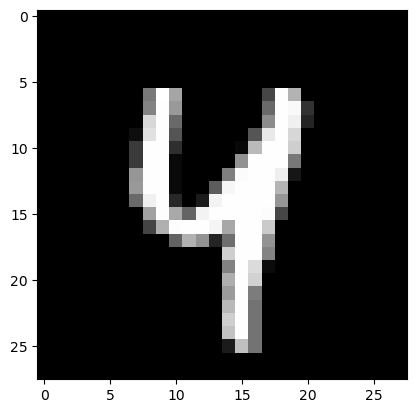

In [60]:
showimg(imgplt)
predict = np.argmax(pred, 0)
print("Predicted label: ", predict)

Lets get model accuracy on Test data set

In [63]:
with torch.no_grad():
    num_correct = 0
    total = 0
    
    for images, labels in testloader:
        output = model(images)
        logoutput = torch.exp(output)
        pred = torch.argmax(output,1)
        total += labels.size(0)
        num_correct += (pred == labels).sum().item()
        
    print("Model accuracy on test images is: %", (num_correct * 100)/total)

Model accuracy on test images is: % 91.46
